# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import autokeras as ak
import tensorflow as tf
import pandas as pd

strategyArray  = []
gainArray      = []
lossArray      = []
channelTypeQnt = 3
ampNumber      = 4

originalDataSet = []
binaryDataSet   = []

gainScalerList = []
lossScalerList = []

originalDataSet.append(pd.read_csv('../datasets/1_channel_type/dataset-{}.txt'.format(ampNumber), sep = ',',header = None))
originalDataSet.append(pd.read_csv('../datasets/2_channel_type/dataset-{}.txt'.format(ampNumber), sep = ',',header = None))
originalDataSet.append(pd.read_csv('../datasets/4_channel_type/dataset-{}.txt'.format(ampNumber), sep = ',',header = None))

for i in range(channelTypeQnt):
    binaryDataSet.append([])
    for line in originalDataSet[i].values:
        myList = [1 if i != 0 else 0 for i in line[:40]]
        myList.extend(line[40:])
        binaryDataSet[i].append(myList)

    binaryDataSet[i] = pd.DataFrame(binaryDataSet[i])
    gainScaler       = MinMaxScaler(feature_range = (-1, 1))
    lossScaler       = MinMaxScaler(feature_range = (-1, 1))

    gainScalerAux = []
    lossScalerAux = []
    
    for j in range(0, ampNumber * 2, 2):
        gainScalerAux.extend(binaryDataSet[i].values[:, 40 + j])
        lossScalerAux.extend(binaryDataSet[i].values[:, 40 + j + 1])

    gainScaler.fit(np.array(gainScalerAux).reshape(-1, 1))
    lossScaler.fit(np.array(lossScalerAux).reshape(-1, 1))
    
    gainScalerList.append(gainScaler)
    lossScalerList.append(lossScaler)

def loadDataset(channelIndex): 
    dataSet = binaryDataSet[channelIndex].values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataSet[channelIndex].values[:, 40 + i])
        gain    = gainScaler.transform(gain.reshape(-1, 1))
        dataSet = np.hstack((dataSet, gain))
        
        loss    = np.array(binaryDataSet[channelIndex].values[:, 40 + i + 1])
        loss    = lossScaler.transform(loss.reshape(-1, 1))
        dataSet = np.hstack((dataSet, loss))
            
    X, y = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    return X, y

def invertGainNorm(value, channelIndex):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return gainScalerList[channelIndex].inverse_transform(auxArray)[0][0]

def invertLossNorm(value, channelIndex):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return lossScalerList[channelIndex].inverse_transform(auxArray)[0][0]
    
def getGainError(value1, value2, channelIndex):
    return (invertGainNorm(value1, channelIndex) - invertGainNorm(value2, channelIndex))**2

def getLossError(value1, value2, channelIndex):
    return (invertLossNorm(value1, channelIndex) - invertLossNorm(value2, channelIndex))**2

X, y = loadDataset(0)

# Cross validation function

In [2]:
def crossValidate(regressor, X, y, folds = 5):
    foldSize   = math.ceil(X.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(X, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(y, np.s_[sliceBegin: sliceEnd], 0)
        
        if isinstance(regressor, Sequential):
            regressor.fit(X_train, y_train, epochs = 500, verbose = 0)  
        else:
            regressor.fit(X_train, y_train)
            
        X_test = X[sliceBegin: sliceEnd]
        y_test = y[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            for i in range(0, ampNumber * 2, 2):
                gainError += getGainError(predicted[i], expected[i], 0) 
                lossError += getLossError(predicted[i + 1], expected[i + 1], 0)
                 
        gainErrors.append(gainError / foldSize)
        lossErrors.append(lossError / foldSize) # average loss error by amp
        
    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy, channelIndex):   
    features, result       = loadDataset(channelIndex)
    gainErrors, lossErrors = crossValidate(strategy, features, result)

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (math.sqrt(np.mean(gainErrors)), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (math.sqrt(np.mean(lossErrors)), lossErrors.std() * 2))
    
    gainArray[channelIndex].append(gainErrors)
    lossArray[channelIndex].append(lossErrors)
    
    return gainErrors, lossErrors

In [4]:
def setANN():
    model = Sequential()
    
    model.add(Dense(4, input_dim = 4, kernel_initializer = 'random_uniform', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid')) 
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(4, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(2, kernel_initializer = 'random_uniform', activation = 'relu'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Plotting functions

In [5]:
def plotErrorBoxPlots():
    fig, axis = plt.subplots(2, 3, figsize = (10, 5))
    
    p1 = axis[0, 0].boxplot(np.sqrt(gainArray[0]))
    axis[0, 0].set_ylabel("Gain error (dB)", fontsize = 8)
    axis[0, 0].set_ylim([1, 8])
    
    axis[0, 1].boxplot(np.sqrt(gainArray[1]))
    axis[0, 1].set_ylim([1, 8])
    
    axis[0, 2].boxplot(np.sqrt(gainArray[2]))
    axis[0, 2].set_ylim([1, 8])
    
    axis[1, 0].boxplot(np.sqrt(lossArray[0]))
    axis[1, 0].set_ylabel("Loss error (dB)", fontsize = 8)
    axis[1, 0].set_xlabel("1 channel type", fontsize = 8)
    axis[1, 0].set_ylim([1, 8])
    
    axis[1, 1].boxplot(np.sqrt(lossArray[1]))
    axis[1, 1].set_xlabel("2 channel type", fontsize = 8)
    axis[1, 1].set_ylim([1, 8])
    #axis[1, 1].get_yaxis().set_visible(False)
    
    axis[1, 2].boxplot(np.sqrt(lossArray[2]))
    axis[1, 2].set_xlabel("4 channel type", fontsize = 8)
    axis[1, 2].set_ylim([1, 8])
    #axis[1, 2].get_yaxis().set_visible(False)
    
    fig.suptitle("Train error", fontsize = 16)
    fig.legend(p1["boxes"], strategyArray, handlelength = 0, bbox_to_anchor=(0.7, 0.81), loc = "right")
    
    #fix scale
    
    plt.show()

In [6]:
def plotGainDistribution(regressor):
    return
    features, result = loadDataset(channelIndex)

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))
    vFunc     = np.vectorize(invertGainNorm)
    
    axis.scatter(vFunc(result[:, 0], 0), vFunc(predicted[:, 0], 0))
    axis.set_title("Gain Distribution")
    axis.set_xlabel("Expected")
    axis.set_ylabel("Predicted")

    plt.show()

In [7]:
def plotLossDistribution(regressor):
    return
    features, result = loadDataset(0)

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))
    vFunc     = np.vectorize(invertLossNorm)
    
    axis.scatter(vFunc(result[:, 1], 0), vFunc(predicted[:, 1], 0), c = "m")
    axis.set_title("Loss Distribution")
    axis.set_xlabel("Expected")
    axis.set_ylabel("Predicted")

    plt.show()

# Putting all together

In [8]:
gainArray = [[],[],[]]
lossArray = [[],[],[]]

In [9]:
for i in range(channelTypeQnt):
    linearSVR = MultiOutputRegressor(SVR(kernel = "rbf", C = 1.0, gamma = 'scale', epsilon = 0.2))
    trainModel(linearSVR, i)
    
strategyArray.append("1 - SVR (Linear)")
plotGainDistribution(linearSVR)
plotLossDistribution(linearSVR)

[21.58320835 21.86504252 27.55063128 27.895692   14.71233066] => 4.77 (+/- 9.64)
[48.91981405 51.71882288 24.44856481 20.84900481 17.42413543] => 5.72 (+/- 29.21)
[29.39897307 32.8499285  20.09637411 28.92567316 20.17538944] => 5.13 (+/- 10.41)
[43.43914558 26.75399239 29.10504676 45.29022157 35.96879976] => 6.01 (+/- 14.82)
[35.69436868 27.19260748 26.67186975 30.04197605 38.40828265] => 5.62 (+/- 9.35)
[34.62107278 35.78605919 37.33286782 43.07815608 23.97190214] => 5.91 (+/- 12.43)


In [10]:
for i in range(channelTypeQnt):
    lasso = MultiOutputRegressor(linear_model.Lasso(alpha = 0.2))
    trainModel(lasso, i)
    
strategyArray.append("2 - Lasso")
plotGainDistribution(lasso)
plotLossDistribution(lasso)

[32.77379752 23.59413141 32.73851026 34.65724045 19.41860162] => 5.35 (+/- 12.02)
[46.57825204 49.35584555 27.91560106 27.85866067 22.69244871] => 5.91 (+/- 21.78)
[28.37858985 30.38018514 19.0231439  29.64700045 18.0904923 ] => 5.01 (+/- 10.78)
[44.38396772 28.58402696 29.93643895 41.8899672  36.80739115] => 6.03 (+/- 12.55)
[27.49828554 28.43946419 27.40352733 26.29727717 38.93603464] => 5.45 (+/- 9.32)
[36.21148468 35.06902894 37.4755598  44.00044441 24.91463336] => 5.96 (+/- 12.29)


In [11]:
for i in range(channelTypeQnt):
    lars = MultiOutputRegressor(linear_model.Lars(n_nonzero_coefs=1))
    trainModel(lars, i)
    
strategyArray.append("3 - LARS")
plotGainDistribution(lars)
plotLossDistribution(lars)

[29.61496167 22.61938123 32.49522555 34.09976163 16.96523658] => 5.21 (+/- 12.87)
[45.31476201 49.93144392 25.95732192 25.77236663 19.15663627] => 5.76 (+/- 24.19)
[28.5627565  30.13108072 18.7510537  29.06868463 17.61369623] => 4.98 (+/- 10.92)
[42.91340148 26.9639055  28.60788632 42.41747349 35.51486529] => 5.94 (+/- 13.35)
[28.24292372 27.93356608 27.14494377 25.87487701 39.47876635] => 5.45 (+/- 9.88)
[35.67438187 34.44158558 35.33063518 43.61830917 25.35706078] => 5.91 (+/- 11.60)


In [12]:
for i in range(channelTypeQnt):
    huber = MultiOutputRegressor(linear_model.HuberRegressor(max_iter = 10000))
    trainModel(huber, i)
    
strategyArray.append("4 - Huber")
plotGainDistribution(huber)
plotLossDistribution(huber)

[23.58863054 25.29711063 28.91421148 30.20505943 21.04375903] => 5.08 (+/- 6.74)
[57.21767334 61.86098725 24.98365341 16.97288668 25.41160959] => 6.11 (+/- 36.95)
[30.23359907 28.47734708 22.94875991 29.07705265 26.49648622] => 5.24 (+/- 5.11)
[48.67275982 29.64794154 30.31189631 43.26407433 43.02604207] => 6.24 (+/- 15.26)
[115.47017786  79.74437945  46.39086074  52.67487419  44.93896956] => 8.24 (+/- 53.85)
[88.68071677 46.41361006 77.65207818 55.2160552  41.53847892] => 7.87 (+/- 36.49)


In [13]:
for i in range(channelTypeQnt):
    knn = MultiOutputRegressor(KNeighborsRegressor())
    trainModel(knn, i)
    
strategyArray.append("5 - KNN")
plotGainDistribution(knn)
plotLossDistribution(knn)

[21.37309417 21.34403587 30.05919283 29.26134529 20.567713  ] => 4.95 (+/- 8.43)
[55.40298475 72.13854709 28.76464375 20.0421716  29.85555755] => 6.42 (+/- 38.88)
[32.25695652 28.70347826 30.2773913  29.67165217 18.96043478] => 5.29 (+/- 9.31)
[45.43415072 30.85034512 31.20675053 54.08505159 35.53901411] => 6.28 (+/- 18.05)
[47.80180879 25.27121447 39.16211886 33.32728682 33.20031008] => 5.98 (+/- 14.94)
[43.50775102 43.03798289 56.24379765 53.00142176 25.35433592] => 6.65 (+/- 21.53)


In [14]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

for i in range(channelTypeQnt):
    extra_tree = ExtraTreeRegressor(criterion = "mse", random_state=0)
    bret = MultiOutputRegressor(BaggingRegressor(base_estimator = extra_tree, n_estimators = 100, random_state = 0))
    trainModel(bret, i)
    
strategyArray.append("6 - Extra Tree")
plotGainDistribution(bret)
plotLossDistribution(bret)

[21.01049276 21.43167554 27.3043061  26.20925267 19.63878614] => 4.81 (+/- 6.10)
[50.01700943 52.04628004 22.4474028  19.77787525 25.43723067] => 5.83 (+/- 28.16)
[25.97032373 29.98334269 21.38577815 29.73108384 18.97699474] => 5.02 (+/- 8.82)
[43.41239393 27.53316602 28.48951598 44.0099398  29.17894271] => 5.88 (+/- 15.04)
[51.64611779 29.75832631 37.6732121  30.02063342 38.14629182] => 6.12 (+/- 15.91)
[40.57129489 37.93122245 37.88723381 43.81941237 29.51247762] => 6.16 (+/- 9.49)


In [15]:
from sklearn.ensemble import RandomForestRegressor

for i in range(channelTypeQnt):
    randomForest = RandomForestRegressor(max_depth = 8, random_state = 0, n_estimators = 100)
    trainModel(randomForest, i)

strategyArray.append("7 - Random Forest")
plotGainDistribution(randomForest)
plotLossDistribution(randomForest)

[21.01049276 21.46644891 27.18976717 26.13753196 19.63878614] => 4.81 (+/- 6.00)
[50.01700943 53.73171166 22.53601812 17.91422664 25.43723067] => 5.82 (+/- 29.79)
[28.04101537 29.96049542 21.36335372 29.8376118  18.65913157] => 5.06 (+/- 9.34)
[43.84174642 27.70744711 28.51620534 44.53837819 28.48756766] => 5.88 (+/- 15.65)
[37.31885947 29.75932302 30.82256418 27.38111359 43.02512696] => 5.80 (+/- 11.45)
[38.94600569 38.65851124 38.14213573 43.50086424 27.69390224] => 6.11 (+/- 10.43)


# Plotting error boxplots

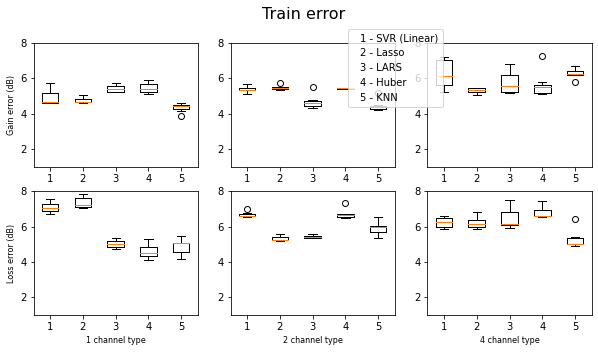

In [16]:
plotErrorBoxPlots()